# LHCb starterkit 2022 - Practice session

## Import 

In [1]:
from typing import Dict, Optional, Tuple
import uproot
import numpy as np
import pandas as pd
import zfit
import matplotlib.pyplot as plt
import matplotlib as mpl
import mplhep
from particle import Particle
import hist

/home/acorreia/softwares/mambaforge/envs/starterkit-env/lib/python3.9/site-packages/zfit/__init__.py:62: UserWarning: TensorFlow warnings are by default suppressed by zfit. In order to show them, set the environment variable ZFIT_DISABLE_TF_WARNINGS=0. In order to suppress the TensorFlow warnings AND this warning, set ZFIT_DISABLE_TF_WARNINGS=1.
  warnings.warn(
2022-12-05 17:12:56.670790: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
mplhep.style.use("LHCb2")

## Labels

In [3]:
#: Columns to load from the ROOT tuple
columns = [
    "D0_M",
    "D0_TRUEID",
    "Kminus_PIDK",
    "Kminus_PIDp",
    "Kminus_PIDmu",
    "Kminus_TRUEID",
    "piplus_PIDK",
    "piplus_PIDp",
    "piplus_PIDmu",
    "piplus_TRUEID"
]

In [4]:
#: List of particles in the tuple
particles = ["D0", "Kminus", "piplus"]

#: Associates a particle with its label
particle_labels = {
    "D0": r"D^{0}",
    "Kminus": r"K^{-}",
    "piplus": r"\pi^{+}",
}

#: Associates a particle characteristic with its label
characteristic_labels = {
    "M": "m",
    "TRUEID": r"\text{TRUEID}",
    "PIDK": r"\text{PID}_{K}",
    "PIDp": r"\text{PID}_{p}",
    "PIDmu": r"\text{PID}_{\mu}",
}

#: Associates a column with its label
column_labels = {
    f"{particle}_{characteristic}":
        f"${characteristic_label}\\left({particle_label}\\right)$"
    for characteristic, characteristic_label in characteristic_labels.items()
    for particle, particle_label in particle_labels.items()
}

## Plotting functions

In [5]:
def plot_hist(
    sample: pd.DataFrame,
    column: str,
    bins: int = 20,
    minv: Optional[float] = None,
    maxv: Optional[float] = None,
    ax: Optional[mpl.axes.Axes] = None,
    **kwargs
) -> mpl.axes.Axes:
    """Plot a one-dimensional histogram of a column in a dataframe.

    Args:
        sample: Pandas dataframe
        column: a column in ``sample``
        bins: number of bins in the histogram
        minv: min value of the histogram range
        maxv: max value of the histogram range
        ax: The matplotlib ax object where the histogram is plotted.
            If not given, it is generated for you.
        kwargs: other arguments passed to :py:`hist.Hist.plot1d`

    Returns:
        the axis ``ax`` where the histogram is plotted
    """
    if ax is None:
        _, ax = plt.subplots()

    if minv is None:
        minv = sample[column].min()
    if maxv is None:
        maxv = sample[column].max()

    histogram = hist.Hist(
        hist.axis.Regular(
            bins,
            minv,
            maxv,
            name=column
        )
    )
    histogram.fill(sample[column])
    histogram.plot1d(ax=ax, **kwargs)
    ax.set_xlabel(column_labels.get(column, column));
    ax.set_ylabel("# candidates")
    return ax

## Load ROOT tuple

Open the ROOT tuple.

In [6]:
path = "ntuple.root"
tree = uproot.open(path)["D0_KmPip/DecayTree"]
dataframe = tree.arrays(columns, library="pd")


<AxesSubplot: xlabel='$m\\left(D^{0}\\right)$', ylabel='# candidates'>

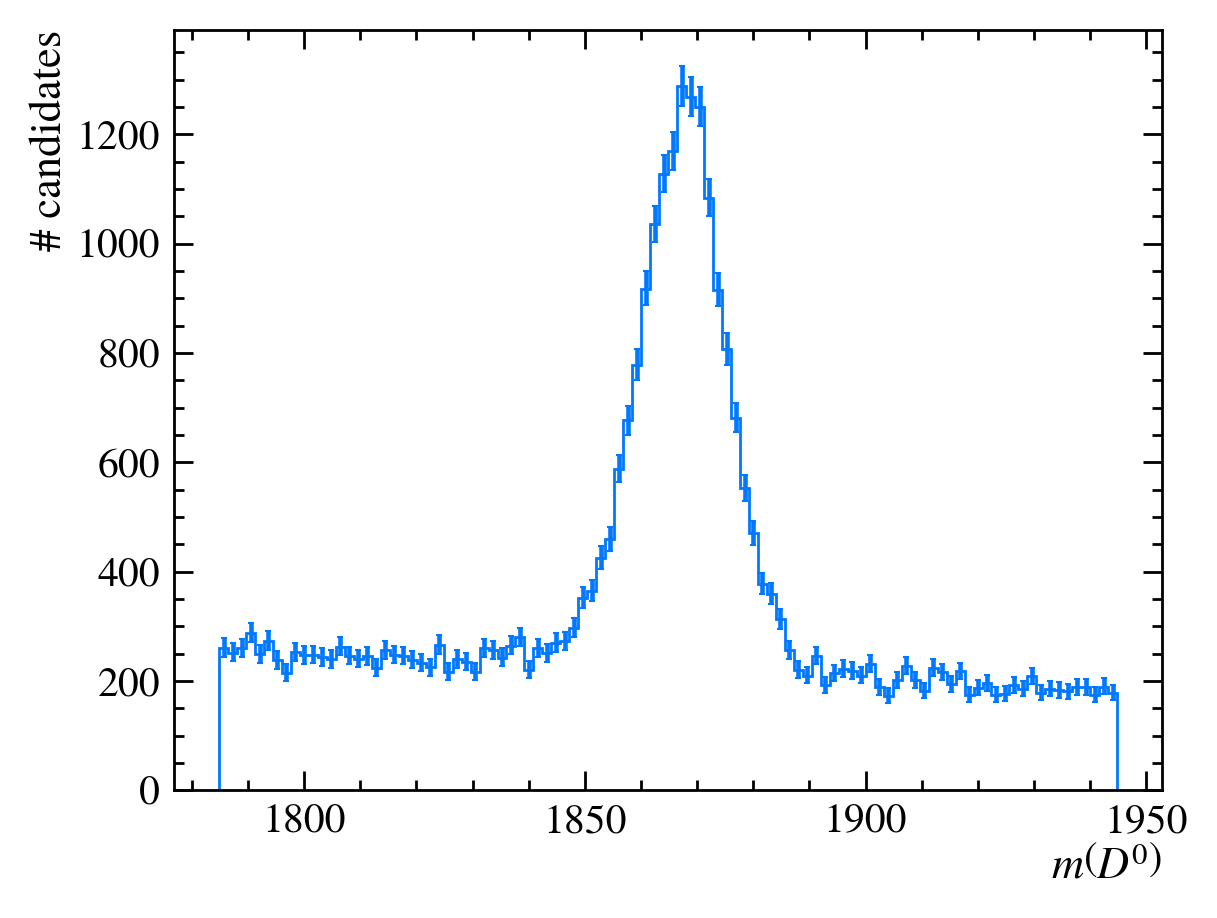

In [7]:
plot_hist(dataframe, "D0_M", 100)

## Truthmatching

The truthmatching uses the `particle` library
([gitlab link](https://github.com/scikit-hep/particle))
to get the PDGIDs of the particles.

In [8]:
def name_to_pdgid(name: str) -> int:
    """Convert a particle name into a pdgid."""
    return int(Particle.from_name(name).pdgid)

def anti_pdgid(pdgid: int) -> int:
    """Invert the PDGID of a particle. For the pion 0 for instance,
    its anti-particle is itself, so the PDGID is unchanged. That is where
    this function might come in handy."""
    return int(Particle.from_pdgid(pdgid).invert().pdgid)

#: Associates a particle with its PDGID
pdgids = {
    "D0": name_to_pdgid("D0"),
    "piplus": name_to_pdgid("pi+"),
    "Kminus": name_to_pdgid("K-")
}

def get_truthmatching_cut(pdgids: Dict[str, int]) -> str:
    """Obtain the truthmatching cut in order to truthmatch the MC sample.

    Args:
        pdgids: a dictionnary that associates a particle with its PDGID for the
            truthmatching.

    Returns:
        Truthmatching requirement. Can be applied to the Pandas dataframe using
        the :py:func:`pd.DataFrame.query` method

    Notes:
        We assume that the PDGID of a particle is given by the column
        ``{particle}_TRUEID``.
    """
    #: List of cuts for truthmatching the decay
    cuts = []
    #: List of cuts for truthmatching the "anti-decay"
    anti_cuts = []

    # Fill the lists
    for particle, pdgid in pdgids.items():
        cuts.append(
            f"({particle}_TRUEID == {pdgid})"
        )
        anti_cuts.append(
            f"({particle}_TRUEID == {anti_pdgid(pdgid)})"
        )
    # Deduce the requirements for the decay and anti-decay
    cut = " and ".join(cuts)
    anti_cut = " and ".join(anti_cuts)
    # Either we have D0 -> pi+ K- or anti-D0 -> pi- K+
    return f"({cut}) or ({anti_cut})"


We apply the truthmatching

In [9]:
cut = get_truthmatching_cut(pdgids)
print(cut)

((D0_TRUEID == 421) and (piplus_TRUEID == 211) and (Kminus_TRUEID == -321)) or ((D0_TRUEID == -421) and (piplus_TRUEID == -211) and (Kminus_TRUEID == 321))


In [10]:
truthmatched_dataframe = dataframe.query(cut)
print(
    "Cut efficiency:",
    len(truthmatched_dataframe) / len(dataframe)
)

Cut efficiency: 0.29292579444107714


<AxesSubplot: xlabel='$m\\left(D^{0}\\right)$', ylabel='# candidates'>

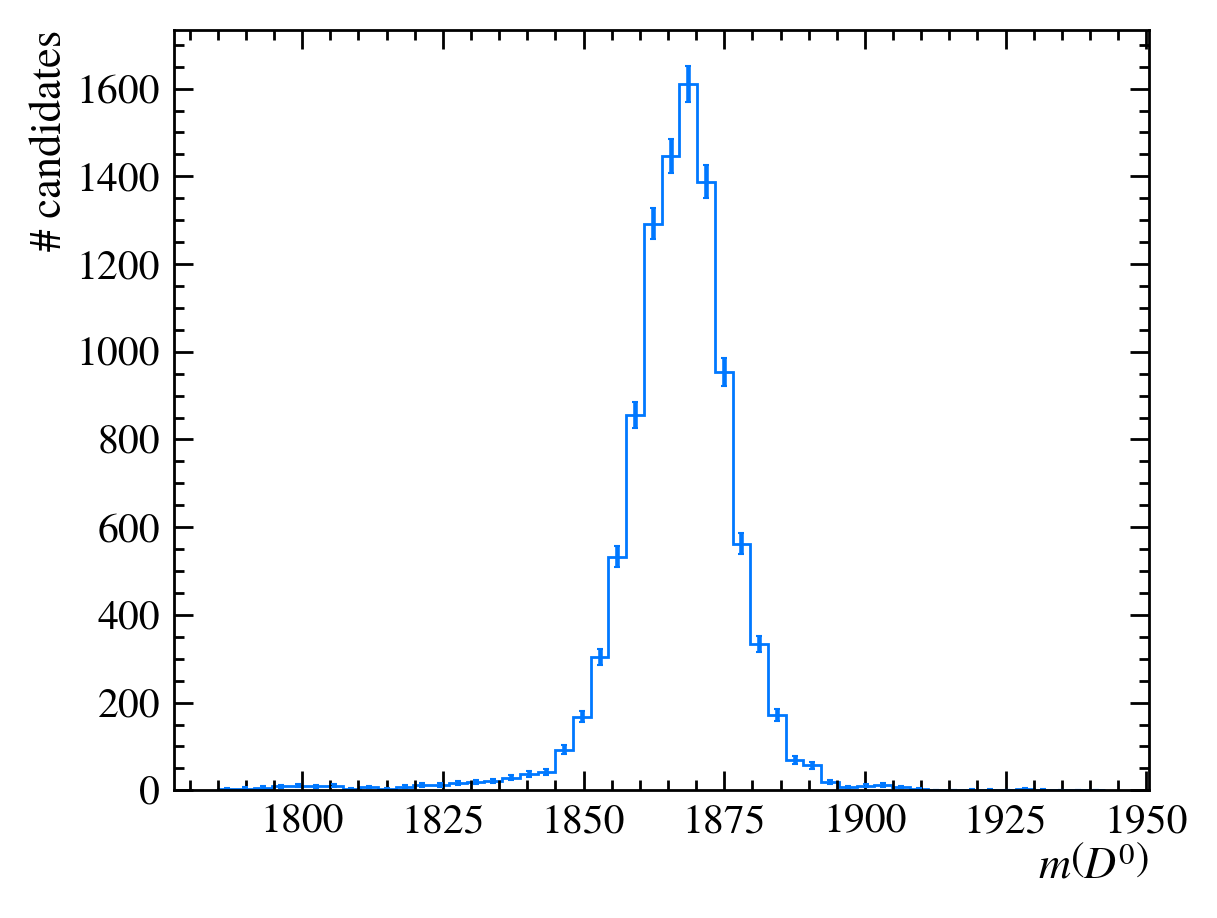

In [11]:
plot_hist(truthmatched_dataframe, "D0_M", 50)

## Fit

### Plotting function

In [18]:
def plot_fit(
    sample: pd.DataFrame,
    model: zfit.pdf.BasePDF,
    bins: int = 50
) -> Tuple[mpl.axes.Axes, mpl.axes.Axes]:
    """A function to plot a one-dimensional histogram in data as well as the overall
    PDF used in the fit. Also plot the pulls at the bottom. This function does not
    plot the sub-models.

    Args:
        sample: pandas dataframe. One of its column was fitted. The column
            is obtained from the ``Space`` object of the ``model``
        model: the overall fitted PDF
        bins: number of bins for the plot

    Returns:
        The matplotlib ``ax`` of the main figure (comparison between
        the fitted model and the fitted histogram) and the one of the pulls.
    """
    # Create the figure
    _, axes = plt.subplots(2, 1, gridspec_kw={'height_ratios': [4, 1]})
    ax = axes[0]
    pull_ax = axes[1]

    # Get the fitted column, the ranges, etc.
    obs = model.space
    fitted_column = model.space.obs[0]
    label = column_labels.get(fitted_column, fitted_column)
    limits = obs.limits
    minv = limits[0][0][0]
    maxv = limits[1][0][0]
    area = obs.area().numpy()[0]

    # Plot the 1-dimensional histogram in data
    histogram = hist.Hist(
        hist.axis.Regular(
            bins,
            minv,
            maxv,
            name=fitted_column
        )
    )
    histogram.fill(sample[fitted_column])
    histogram.plot1d(ax=ax, label="MC data", color='k')
    ax.set_xlabel(label)
    ax.set_ylabel("# candidates")

    # Plot the model on top of the fitted data histogram
    x = np.linspace(minv, maxv, 1000)
    model_yield = model.get_yield().numpy()
    model_array = (
        model.pdf(x).numpy()
        * area
        * model_yield
        / bins
    )
    ax.plot(x, model_array, label="PDF", color='b')
    ax.legend()

    # Plot the pulls at the bottom
    x_pull = histogram.axes[0].centers
    model_pull_array = (
        model.pdf(x_pull).numpy()
        * area
        * model_yield
        / bins
    )
    pulls = (histogram.counts() - model_pull_array) / np.sqrt(histogram.variances())
    pull_ax.errorbar(
        x_pull,
        pulls,
        yerr=1,
        linewidth=0,
        marker='.',
        elinewidth=3,
        color='k'
    )
    pull_ax.axhline(y=0, color='grey', alpha=0.5, linewidth=1.)
    pull_ax.set_ylim(-5, 5)
    pull_ax.set_xlabel(label)
    pull_ax.set_ylabel("Pulls")
    return ax, pull_ax

### The actual model

In [13]:
fitted_column = "D0_M"
fit_range = (1820, 1910)

In [14]:
obs = zfit.Space(
    fitted_column,
    limits=fit_range
)


In [15]:
mu = zfit.Parameter(
    "mu", dataframe[fitted_column].mean(),
    dataframe[fitted_column].mean() - 5,
    dataframe[fitted_column].mean() + 5
)
sigma = zfit.Parameter(
    "sigma",
    5.,
    1., 10.,
)

alphal = zfit.Parameter(
    "alphal",
    5,
    0.1, 100
)
alphar = zfit.Parameter(
    "alphar",
    5,
    0.1, 50.
)
nl = zfit.Parameter(
    "nl",
    5,
    0.1, 160
)
nr = zfit.Parameter(
    "nr",
    5,
    0.1, 160
)

n_truthmatched = len(truthmatched_dataframe)
n_signal = zfit.Parameter(
    'n_signal',
    n_truthmatched, n_truthmatched*0.5, n_truthmatched*1.5
)
signal_model = zfit.pdf.Gauss(
    obs=obs,
    mu=mu,
    sigma=sigma,
)

signal_model = zfit.pdf.DoubleCB(
    mu=mu,
    sigma=sigma,
    alphal=alphal,
    nl=nl,
    alphar=alphar,
    nr=nr,
    obs=obs
)

ext_signal_model = signal_model.create_extended(n_signal)


In [16]:
# fitted data
data_zfit = zfit.Data.from_pandas(
    truthmatched_dataframe,
    obs=obs
)
# minimiser and likelihood
minimiser = zfit.minimize.Minuit(
    mode=1)
nll_unbinned = zfit.loss.ExtendedUnbinnedNLL(
    model=ext_signal_model,
    data=data_zfit
)

# Minimisation
result = minimiser.minimize(nll_unbinned)
result.hesse(name="minuit_hesse")
result

FitResult of
<ExtendedUnbinnedNLL model=[<zfit.<class 'zfit.models.physics.DoubleCB'>  params=[alphal, alphar, mu, nl, nr, sigma]] data=[<zfit.core.data.Data object at 0x7f6c84338ee0>] constraints=[]> 
with
<Minuit Minuit tol=0.001>

╒═════════╤═════════════╤══════════════════╤═════════╤═════════════╕
│ valid   │ converged   │ param at limit   │ edm     │ min value   │
╞═════════╪═════════════╪══════════════════╪═════════╪═════════════╡
│ True    │ True        │ False            │ 0.00016 │ -8335.322   │
╘═════════╧═════════════╧══════════════════╧═════════╧═════════════╛

Parameters
name        value  (rounded)    minuit_hesse    at limit
--------  ------------------  --------------  ----------
n_signal             10069.7     +/-   1e+02       False
mu                   1867.39     +/-   0.098       False
sigma                7.66333     +/-    0.12       False
alphal               1.72592     +/-    0.12       False
nl                   2.99993     +/-    0.72       False
alphar    

### Plot the fit result

/tmp/ipykernel_37428/431439028.py:68: RuntimeWarning: divide by zero encountered in divide
  pulls = (histogram.counts() - model_pull_array) / np.sqrt(histogram.variances())


(<AxesSubplot: xlabel='$m\\left(D^{0}\\right)$', ylabel='# candidates'>,
 <AxesSubplot: xlabel='$m\\left(D^{0}\\right)$', ylabel='Pulls'>)

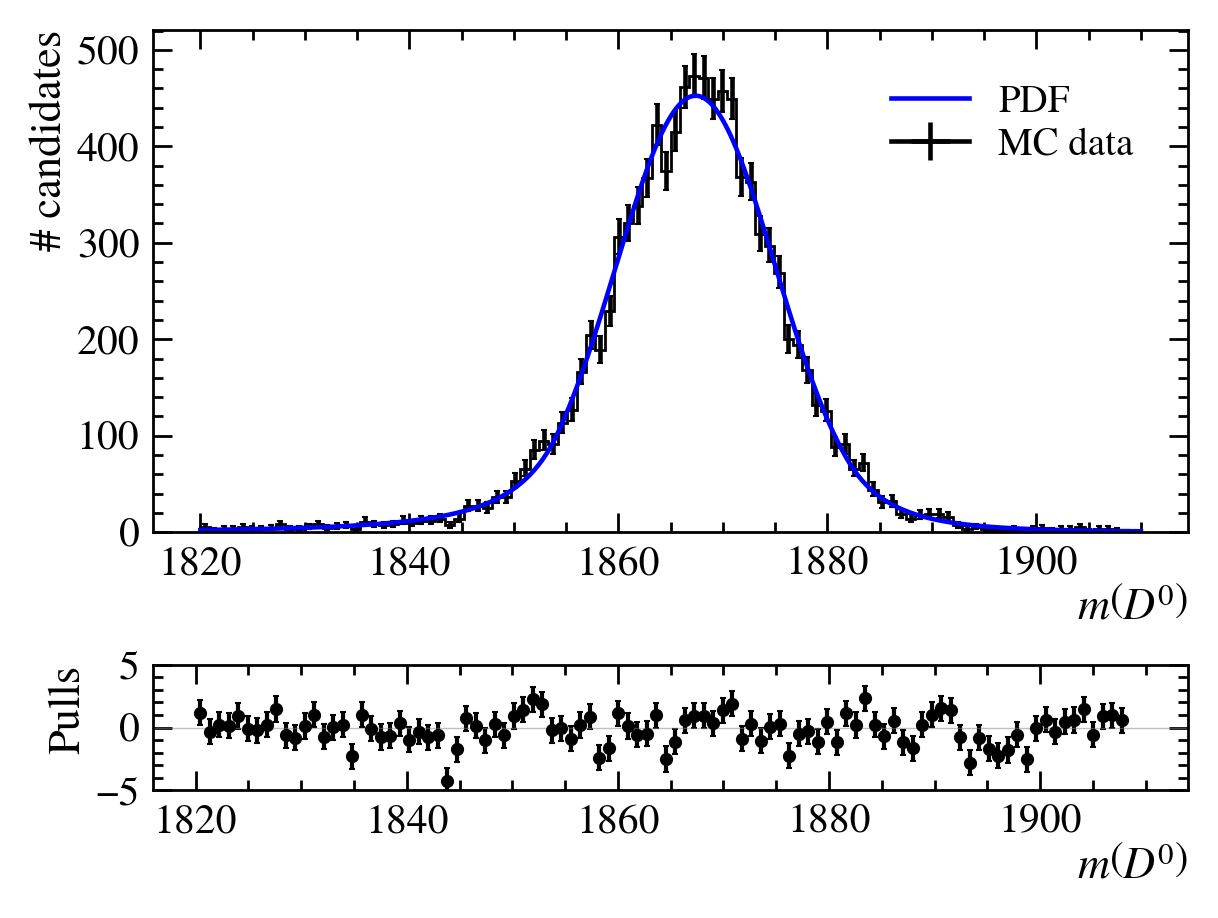

In [19]:
plot_fit(
    truthmatched_dataframe,
    ext_signal_model,
    bins=100
)